Initial Imports

In [77]:
import csv
import time
import openmeteo_requests
import requests_cache
from retry_requests import retry
import pandas as pd
from datetime import datetime, timedelta
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate map of cities and their respective coordinates

In [41]:
# Replace 'file.csv' with your CSV file's name and path
file_path = 'data/tr.csv'

# Create an empty dictionary to store city coordinates
city_coordinates = {}

# Open the CSV file and read data
with open(file_path, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        city = row['city']
        lat = float(row['lat'])
        lng = float(row['lng'])
        city_coordinates[city] = (lat, lng)

# Display the dictionary containing city coordinates
for city, coordinates in city_coordinates.items():
    print(f"City: {city}, Coordinates: {coordinates}")
city_coordinates

City: Istanbul, Coordinates: (41.0136, 28.955)
City: Ankara, Coordinates: (39.93, 32.85)
City: İzmir, Coordinates: (38.42, 27.14)
City: Bursa, Coordinates: (40.1833, 29.05)
City: Antalya, Coordinates: (36.8874, 30.7075)
City: Konya, Coordinates: (37.8667, 32.4833)
City: Gaziantep, Coordinates: (37.0628, 37.3792)
City: Şanlıurfa, Coordinates: (37.1583, 38.7917)
City: Mersin, Coordinates: (36.8, 34.6333)
City: Adana, Coordinates: (37.0, 35.3213)
City: Diyarbakır, Coordinates: (37.91, 40.24)
City: Kayseri, Coordinates: (38.7225, 35.4875)
City: Samsun, Coordinates: (41.2903, 36.3336)
City: Akçaabat, Coordinates: (41.0167, 39.55)
City: Denizli, Coordinates: (37.7667, 29.0833)
City: Çankaya, Coordinates: (39.9244, 32.8856)
City: Esenyurt, Coordinates: (41.047, 28.658)
City: Eskişehir, Coordinates: (39.7767, 30.5206)
City: Seyhan, Coordinates: (36.9831, 35.3328)
City: Küçükçekmece, Coordinates: (41.0, 28.8)
City: Erzurum, Coordinates: (39.9086, 41.2769)
City: Bağcılar, Coordinates: (41.0344, 

{'Istanbul': (41.0136, 28.955),
 'Ankara': (39.93, 32.85),
 'İzmir': (38.42, 27.14),
 'Bursa': (40.1833, 29.05),
 'Antalya': (36.8874, 30.7075),
 'Konya': (37.8667, 32.4833),
 'Gaziantep': (37.0628, 37.3792),
 'Şanlıurfa': (37.1583, 38.7917),
 'Mersin': (36.8, 34.6333),
 'Adana': (37.0, 35.3213),
 'Diyarbakır': (37.91, 40.24),
 'Kayseri': (38.7225, 35.4875),
 'Samsun': (41.2903, 36.3336),
 'Akçaabat': (41.0167, 39.55),
 'Denizli': (37.7667, 29.0833),
 'Çankaya': (39.9244, 32.8856),
 'Esenyurt': (41.047, 28.658),
 'Eskişehir': (39.7767, 30.5206),
 'Seyhan': (36.9831, 35.3328),
 'Küçükçekmece': (41.0, 28.8),
 'Erzurum': (39.9086, 41.2769),
 'Bağcılar': (41.0344, 28.8564),
 'Pendik': (40.8747, 29.235),
 'Selçuklu': (37.8814, 32.4922),
 'Yıldırım': (40.11, 29.0821),
 'Kartal': (40.8872, 29.19),
 'Batman': (37.887, 41.132),
 'Esenler': (41.0339, 28.8903),
 'Kahramanmaraş': (37.5833, 36.9333),
 'Kâğıthane': (41.0719, 28.9664),
 'Avcılar': (40.9792, 28.7214),
 'Trabzon': (41.005, 39.7225),
 '

In [42]:

today = datetime.now()  # Get today's date
one_year_ago = today - timedelta(days=365)  # Subtract 365 days for one year
today

datetime.datetime(2024, 1, 7, 18, 20, 36, 403376)

In [43]:
def format_date(date):
	formatted_date = date.strftime('%Y-%m-%d')
	return formatted_date

In [44]:
class OpenMeteoRequestsError(Exception):
    pass

In [45]:
def api_call(lat,long):
	# Setup the Open-Meteo API client with cache and retry on error
	cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
	retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
	openmeteo = openmeteo_requests.Client(session = retry_session)
	
	# Make sure all required weather variables are listed here
	# The order of variables in hourly or daily is important to assign them correctly below
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
		"latitude": lat,
		"longitude": long,
		"start_date": format_date(one_year_ago),
		"end_date": format_date(today),
		"hourly": ["temperature_2m", "relative_humidity_2m", "rain", "snowfall", "surface_pressure", "cloud_cover", "wind_speed_10m"]
	}
	responses = openmeteo.weather_api(url, params=params)
	
	# Process first location. Add a for-loop for multiple locations or weather models
	response = responses[0]
	print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
	print(f"Elevation {response.Elevation()} m asl")
	print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
	print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")
	
	# Process hourly data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
	hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
	hourly_rain = hourly.Variables(2).ValuesAsNumpy()
	hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()
	hourly_surface_pressure = hourly.Variables(4).ValuesAsNumpy()
	hourly_cloud_cover = hourly.Variables(5).ValuesAsNumpy()
	hourly_wind_speed_10m = hourly.Variables(6).ValuesAsNumpy()
	
	hourly_data = {"date": pd.date_range(
		start=pd.to_datetime(hourly.Time(), unit="s"),
		end=pd.to_datetime(hourly.TimeEnd(), unit="s"),
		freq=pd.Timedelta(seconds=hourly.Interval()),
		inclusive="left"
	), "temperature_2m": hourly_temperature_2m, "relative_humidity_2m": hourly_relative_humidity_2m, "rain": hourly_rain,
		"snowfall": hourly_snowfall, "surface_pressure": hourly_surface_pressure, "cloud_cover": hourly_cloud_cover,
		"wind_speed_10m": hourly_wind_speed_10m}
	
	hourly_dataframe = pd.DataFrame(data = hourly_data)
	return hourly_dataframe

In [46]:
data_frame = pd.DataFrame()

for city in city_coordinates:
    time.sleep(1)
    df = api_call(lat, lng)
    if data_frame.empty:
        data_frame = df
    else:
        data_frame = pd.concat((data_frame, df))
data_frame

Coordinates 40.808433532714844°E 29.40340805053711°N
Elevation 57.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 40.808433532714844°E 29.40340805053711°N
Elevation 57.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 40.808433532714844°E 29.40340805053711°N
Elevation 57.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 40.808433532714844°E 29.40340805053711°N
Elevation 57.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 40.808433532714844°E 29.40340805053711°N
Elevation 57.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 40.808433532714844°E 29.40340805053711°N
Elevation 57.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 40.808433532714844°E 29.40340805053711°N
Elevation 57.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Coordinates 40.808433532714844°E 29.40340805053711°N
Elevation 57.0 m asl
Timezone None None
Timezone difference to GM

,date,temperature_2m,relative_humidity_2m,rain,snowfall,surface_pressure,cloud_cover,wind_speed_10m
0,2023-01-07 00:00:00,7.594,82.153587,0.0,0.0,1017.621765,14.400001,9.504272
1,2023-01-07 01:00:00,6.794,83.208969,0.0,0.0,1017.899597,8.700000,7.787991
2,2023-01-07 02:00:00,6.444,84.046982,0.0,0.0,1017.692139,36.299999,6.989936
3,2023-01-07 03:00:00,6.194,85.507019,0.0,0.0,1017.785034,68.100006,6.489992
4,2023-01-07 04:00:00,6.444,86.135239,0.0,0.0,1018.089233,68.400002,6.489992
...,...,...,...,...,...,...,...,...
8779,2024-01-07 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8780,2024-01-07 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8781,2024-01-07 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8782,2024-01-07 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
data_frame.head()

,date,temperature_2m,relative_humidity_2m,rain,snowfall,surface_pressure,cloud_cover,wind_speed_10m
0,2023-01-07 00:00:00,7.594,82.153587,0.0,0.0,1017.621765,14.400001,9.504272
1,2023-01-07 01:00:00,6.794,83.208969,0.0,0.0,1017.899597,8.700000,7.787991
2,2023-01-07 02:00:00,6.444,84.046982,0.0,0.0,1017.692139,36.299999,6.989936
3,2023-01-07 03:00:00,6.194,85.507019,0.0,0.0,1017.785034,68.100006,6.489992
4,2023-01-07 04:00:00,6.444,86.135239,0.0,0.0,1018.089233,68.400002,6.489992


# Feature selection

In [48]:
selected_features = data_frame.drop(columns=['temperature_2m', 'relative_humidity_2m','surface_pressure'])

target_variables = ['rain','snowfall', 'cloud_cover', 'wind_speed_10m']

# Assuming you want to predict each target variable for the next hour
for target_variable in target_variables:
    # Shift the target variable by 1 hour to align with features
    data_frame[target_variable] = data_frame[target_variable].shift(-1)

# Drop the last row to maintain alignment of features and labels
data_frame = data_frame.dropna()
data_frame

,date,temperature_2m,relative_humidity_2m,rain,snowfall,surface_pressure,cloud_cover,wind_speed_10m
0,2023-01-07 00:00:00,7.594000,82.153587,0.0,0.0,1017.621765,8.700000,7.787991
1,2023-01-07 01:00:00,6.794000,83.208969,0.0,0.0,1017.899597,36.299999,6.989936
2,2023-01-07 02:00:00,6.444000,84.046982,0.0,0.0,1017.692139,68.100006,6.489992
3,2023-01-07 03:00:00,6.194000,85.507019,0.0,0.0,1017.785034,68.400002,6.489992
4,2023-01-07 04:00:00,6.444000,86.135239,0.0,0.0,1018.089233,36.600002,5.991594
...,...,...,...,...,...,...,...,...
8730,2024-01-05 18:00:00,9.493999,81.832985,0.0,0.0,1013.100952,0.300000,7.928178
8731,2024-01-05 19:00:00,8.444000,85.157410,0.0,0.0,1013.372742,17.100000,10.105681
8732,2024-01-05 20:00:00,8.444000,81.978683,0.0,0.0,1013.472046,12.600000,12.015589
8733,2024-01-05 21:00:00,8.743999,76.516251,0.0,0.0,1013.181458,21.300001,12.144331


In [49]:
# Splitting features and labels
X = data_frame[selected_features.columns]  # Features
X

,date,rain,snowfall,cloud_cover,wind_speed_10m
0,2023-01-07 00:00:00,0.0,0.0,8.700000,7.787991
1,2023-01-07 01:00:00,0.0,0.0,36.299999,6.989936
2,2023-01-07 02:00:00,0.0,0.0,68.100006,6.489992
3,2023-01-07 03:00:00,0.0,0.0,68.400002,6.489992
4,2023-01-07 04:00:00,0.0,0.0,36.600002,5.991594
...,...,...,...,...,...
8730,2024-01-05 18:00:00,0.0,0.0,0.300000,7.928178
8731,2024-01-05 19:00:00,0.0,0.0,17.100000,10.105681
8732,2024-01-05 20:00:00,0.0,0.0,12.600000,12.015589
8733,2024-01-05 21:00:00,0.0,0.0,21.300001,12.144331


In [50]:
y = data_frame[target_variables]  # Labels
y

,rain,snowfall,cloud_cover,wind_speed_10m
0,0.0,0.0,8.700000,7.787991
1,0.0,0.0,36.299999,6.989936
2,0.0,0.0,68.100006,6.489992
3,0.0,0.0,68.400002,6.489992
4,0.0,0.0,36.600002,5.991594
...,...,...,...,...
8730,0.0,0.0,0.300000,7.928178
8731,0.0,0.0,17.100000,10.105681
8732,0.0,0.0,12.600000,12.015589
8733,0.0,0.0,21.300001,12.144331


# Creating Test and Training Data

In [54]:
# Select numerical columns only for conversion to tensors
numerical_columns_X = X.select_dtypes(include=['float32', 'float64']).columns
X_numeric = X[numerical_columns_X]
X_numeric

,rain,snowfall,cloud_cover,wind_speed_10m
0,0.0,0.0,8.700000,7.787991
1,0.0,0.0,36.299999,6.989936
2,0.0,0.0,68.100006,6.489992
3,0.0,0.0,68.400002,6.489992
4,0.0,0.0,36.600002,5.991594
...,...,...,...,...
8730,0.0,0.0,0.300000,7.928178
8731,0.0,0.0,17.100000,10.105681
8732,0.0,0.0,12.600000,12.015589
8733,0.0,0.0,21.300001,12.144331


In [55]:
numerical_columns_y = y.select_dtypes(include=['float32', 'float64']).columns
y_numeric = y[numerical_columns_y]
y_numeric

,rain,snowfall,cloud_cover,wind_speed_10m
0,0.0,0.0,8.700000,7.787991
1,0.0,0.0,36.299999,6.989936
2,0.0,0.0,68.100006,6.489992
3,0.0,0.0,68.400002,6.489992
4,0.0,0.0,36.600002,5.991594
...,...,...,...,...
8730,0.0,0.0,0.300000,7.928178
8731,0.0,0.0,17.100000,10.105681
8732,0.0,0.0,12.600000,12.015589
8733,0.0,0.0,21.300001,12.144331


In [56]:
# Convert numerical columns to PyTorch tensors
X_tensor = torch.tensor(X_numeric.values, dtype=torch.float32)
X_tensor

tensor([[ 0.0000,  0.0000,  8.7000,  7.7880],
        [ 0.0000,  0.0000, 36.3000,  6.9899],
        [ 0.0000,  0.0000, 68.1000,  6.4900],
        ...,
        [ 0.0000,  0.0000, 12.6000, 12.0156],
        [ 0.0000,  0.0000, 21.3000, 12.1443],
        [ 0.0000,  0.0000, 15.3000, 12.2241]])

In [57]:
y_tensor = torch.tensor(y_numeric.values, dtype=torch.float32)
y_tensor

tensor([[ 0.0000,  0.0000,  8.7000,  7.7880],
        [ 0.0000,  0.0000, 36.3000,  6.9899],
        [ 0.0000,  0.0000, 68.1000,  6.4900],
        ...,
        [ 0.0000,  0.0000, 12.6000, 12.0156],
        [ 0.0000,  0.0000, 21.3000, 12.1443],
        [ 0.0000,  0.0000, 15.3000, 12.2241]])

In [58]:
# Split data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test

(tensor([[  0.0000,   0.0000,  21.6000,   1.1384],
         [  0.0000,   0.0000,   0.0000,   4.3944],
         [  0.0000,   0.0000, 100.0000,   1.5274],
         ...,
         [  0.0000,   0.0000,   0.0000,   9.4496],
         [  0.0000,   0.0000,  19.5000,   7.5170],
         [  0.0000,   0.0000,   0.9000,   8.4963]]),
 tensor([[  1.1000,   0.0000, 100.0000,  12.5949],
         [  0.0000,   0.0000,  39.6000,   7.2805],
         [  0.0000,   0.0000,  37.2000,   8.4274],
         ...,
         [  0.0000,   0.0000,   0.9000,   5.8048],
         [  1.6000,   0.0000,  90.0000,   4.6800],
         [  0.0000,   0.0000, 100.0000,  13.3928]]),
 tensor([[  0.0000,   0.0000,  21.6000,   1.1384],
         [  0.0000,   0.0000,   0.0000,   4.3944],
         [  0.0000,   0.0000, 100.0000,   1.5274],
         ...,
         [  0.0000,   0.0000,   0.0000,   9.4496],
         [  0.0000,   0.0000,  19.5000,   7.5170],
         [  0.0000,   0.0000,   0.9000,   8.4963]]),
 tensor([[  1.1000,   0.0000, 100.

In [59]:
# Create PyTorch datasets
train_dataset = TensorDataset(X_train, y_train)
train_dataset

In [60]:
test_dataset = TensorDataset(X_test, y_test)
test_dataset

In [61]:
# Define batch size for DataLoader
batch_size = 64
batch_size

64

In [62]:
# Create DataLoaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader

In [63]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loader

In [65]:
# Define a simple feedforward neural network
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input layer
        self.relu = nn.ReLU()  # Activation function
        self.fc2 = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [66]:
# Define input, hidden, and output sizes based on your data
input_size = X_train.shape[1]  # Number of features
hidden_size = 64  # Number of neurons in the hidden layer
output_size = y_train.shape[1]  # Number of output variables

In [67]:
# Create an instance of the model
model = SimpleModel(input_size, hidden_size, output_size)
model

SimpleModel(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

In [68]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [69]:
# Train the model
num_epochs = 10  # Number of training epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print training loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/10], Loss: 1.8971
Epoch [2/10], Loss: 0.0006
Epoch [3/10], Loss: 0.0005
Epoch [4/10], Loss: 0.0004
Epoch [5/10], Loss: 0.0005
Epoch [6/10], Loss: 0.0004
Epoch [7/10], Loss: 0.0004
Epoch [8/10], Loss: 0.0004
Epoch [9/10], Loss: 0.0003
Epoch [10/10], Loss: 0.0003


In [71]:
# Evaluate the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")

Test Loss: 0.0000


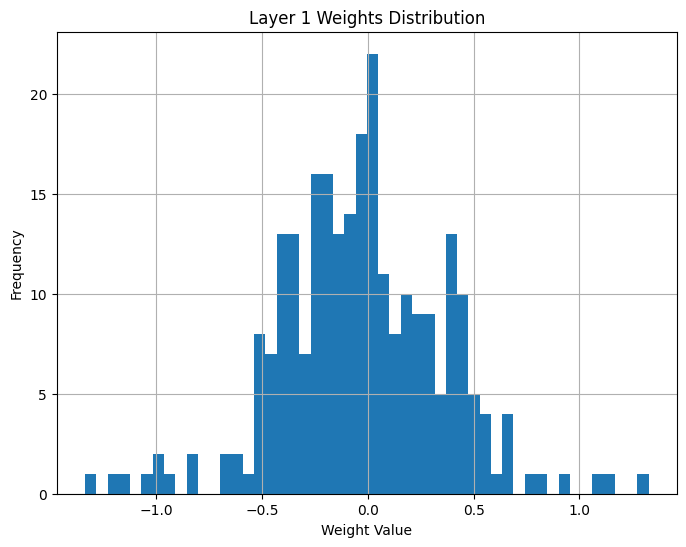

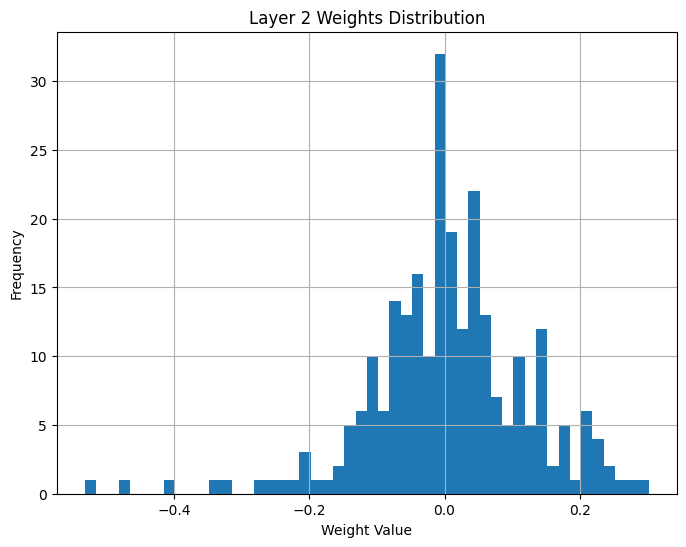

In [78]:


# Extract weights from the model's layers
def extract_weights(model):
    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights.append(param.detach().numpy())
    return weights

# Get the weights from the model
model_weights = extract_weights(model)

# Visualize the weights of each layer
for i, layer_weights in enumerate(model_weights, 1):
    plt.figure(figsize=(8, 6))
    plt.hist(layer_weights.flatten(), bins=50)
    plt.title(f"Layer {i} Weights Distribution")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
